In [18]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

## Chat-GPT Code

#### Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

#### Hyperparameters

In [2]:
batch_size = 32
num_epochs = 10
learning_rate = 0.05

transform = transforms.Compose(
  [transforms.Resize((224, 224)), # Resize images to 224x224 pixels
  transforms.ToTensor(), # Convert images to tensors
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Normalize images

#### Train-Validation-Test Sets

In [3]:
TRAIN_PATH = "/kaggle/input/intel-image-classification/seg_train/seg_train"
trainset = torchvision.datasets.ImageFolder(root=TRAIN_PATH, transform=transform)

validation_size = int(0.05 * len(trainset))
training_size = len(trainset) - validation_size

trainset , validationset = torch.utils.data.random_split(trainset, [training_size,validation_size]) 

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
print(f"Training Set Images : {len(trainset)}")

validationloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size, shuffle=True)
print(f"Validation Set Images : {len(validationset)}")

Training Set Images : 13333
Training Set Images : 701


In [4]:
TEST_PATH = "/kaggle/input/intel-image-classification/seg_test/seg_test"
testset = torchvision.datasets.ImageFolder(root=TEST_PATH, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
print(f"Testing Set Images : {len(testset)}")

Testing Set Images : 3000


#### Architecture

In [5]:
class IntelNet(nn.Module):
    
    def __init__(self):
            super(IntelNet, self).__init__()
        
           # Convolutional layers
            self.conv1 = nn.Conv2d(3, 16, 3) # Input channels: 3, output channels: 16, kernel size: 3
            self.conv2 = nn.Conv2d(16, 32, 3) # Input channels: 16, output channels: 32, kernel size: 3
            self.conv3 = nn.Conv2d(32, 64, 3) # Input channels: 32, output channels: 64, kernel size: 3
        
           # Pooling layer
            self.pool = nn.MaxPool2d(2, 2) # Kernel size: 2, stride: 2
        
           # Fully connected layers
            self.fc1 = nn.Linear(64 * 26 * 26, 256) # Input features: 64 * 26 * 26, output features: 256
            self.fc2 = nn.Linear(256, 6) # Input features: 256, output features: 17 (number of classes)
            
           # Activation function
            self.relu = nn.ReLU()

    def forward(self, x):
        
           # Apply convolutional layers and pooling layers
            x = self.pool(self.relu(self.conv1(x)))
            x = self.pool(self.relu(self.conv2(x)))
            x = self.pool(self.relu(self.conv3(x)))
        
           # Flatten the output
            x = x.view(-1, 64 * 26 * 26)
        
           # Apply fully connected layers
            x = self.relu(self.fc1(x))
            x = self.fc2(x)
            
            return x

#### Activate GPUs

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### Training & Validating

In [7]:
# Create an instance of the model
model = IntelNet().to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [8]:
# Initialize lists to store training and validation losses and accuracies
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Train the model
for epoch in range(num_epochs):
    
    print(f"\n\nProcessing Epoch : {epoch + 1}")
    running_loss = 0.0
    running_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0
    
    # Loop over the training batches
    print(f".. .. Training")
    for i, data in enumerate(trainloader):
        
        # Get the inputs and the labels
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs).to(device)
        
        # Compute the loss and the accuracy
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        acc = torch.sum(preds == labels).item() / batch_size
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Print statistics
        running_loss += loss.item()
        running_acc += acc
        
        if i % 200 == 199:  # Print every 200 mini-batches
            print('[%d, %5d] loss: %.3f accuracy: %.3f' % (epoch + 1, i + 1, running_loss / 200, running_acc / 200))
            running_loss = 0.0
            running_acc = 0.0
    
    # Calculate training loss and accuracy for the epoch
    epoch_train_loss = running_loss / len(trainloader)
    epoch_train_acc = running_acc / len(trainloader)
    
    # Append training loss and accuracy to the lists
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    
    # Loop over the validation batches
    print(f".. .. Validating")
    with torch.no_grad():
        for data in validationloader:
            
            # Get the inputs and the labels
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Compute the loss and the accuracy
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            acc = torch.sum(preds == labels).item() / batch_size
            
            # Print statistics
            val_loss += loss.item()
            val_acc += acc
        
        # Calculate validation loss and accuracy for the epoch
        epoch_val_loss = val_loss / len(validationloader)
        epoch_val_acc = val_acc / len(validationloader)
        
        # Append validation loss and accuracy to the lists
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)
    
    # Print training and validation results for the epoch
    print('Epoch [%d/%d] Training loss: %.3f accuracy: %.3f | Validation loss: %.3f accuracy: %.3f' %
          (epoch + 1, num_epochs, epoch_train_loss, epoch_train_acc, epoch_val_loss, epoch_val_acc))



Processing Epoch : 1
.. .. Training
[1,   200] loss: 1.316 accuracy: 0.463
[1,   400] loss: 1.035 accuracy: 0.590
.. .. Validating
Epoch [1/15] Training loss: 0.045 accuracy: 0.023 | Validation loss: 0.950 accuracy: 0.648


Processing Epoch : 2
.. .. Training
[2,   200] loss: 0.922 accuracy: 0.641
[2,   400] loss: 0.827 accuracy: 0.685
.. .. Validating
Epoch [2/15] Training loss: 0.029 accuracy: 0.029 | Validation loss: 0.706 accuracy: 0.729


Processing Epoch : 3
.. .. Training
[3,   200] loss: 0.712 accuracy: 0.734
[3,   400] loss: 0.655 accuracy: 0.758
.. .. Validating
Epoch [3/15] Training loss: 0.026 accuracy: 0.030 | Validation loss: 0.774 accuracy: 0.717


Processing Epoch : 4
.. .. Training
[4,   200] loss: 0.548 accuracy: 0.807
[4,   400] loss: 0.546 accuracy: 0.794
.. .. Validating
Epoch [4/15] Training loss: 0.022 accuracy: 0.032 | Validation loss: 0.581 accuracy: 0.773


Processing Epoch : 5
.. .. Training
[5,   200] loss: 0.439 accuracy: 0.844
[5,   400] loss: 0.403 accu

#### Visualizing Losses & Accuracy

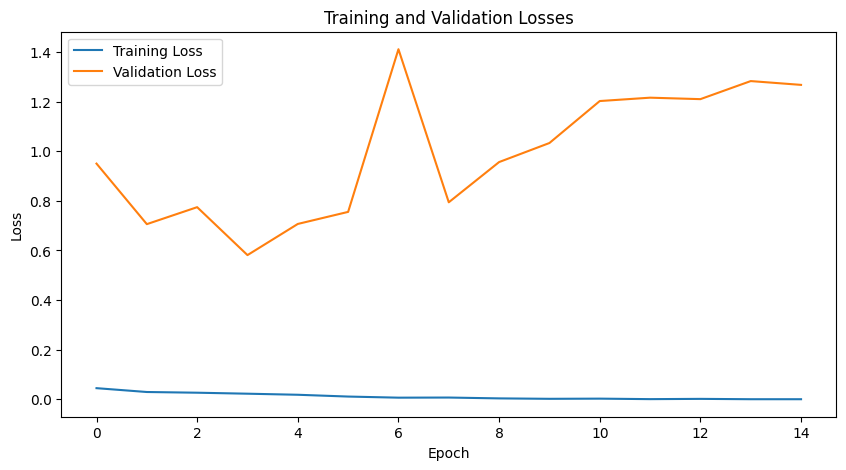

In [13]:
# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Training and Validation Losses')
plt.legend()

plt.show()

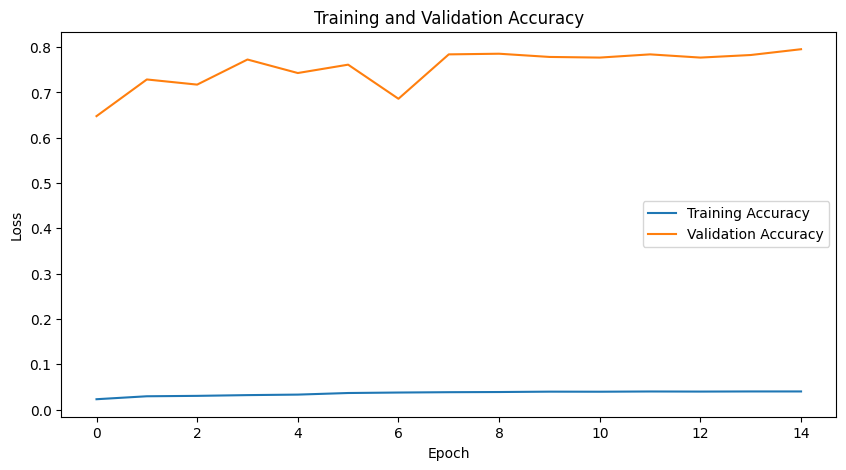

In [14]:
# Plot training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

#### Testing

In [11]:
# Evaluation Mode : On
model.eval()

IntelNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=43264, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=6, bias=True)
  (relu): ReLU()
)

In [12]:
test_loss = 0.0
test_acc = 0.0

with torch.no_grad():
    for data in testloader:
        
        # Get the inputs and labels
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Compute the accuracy
        _, preds = torch.max(outputs, 1)
        acc = torch.sum(preds == labels).item() / batch_size

        # Accumulate test loss and accuracy
        test_loss += loss.item()
        test_acc += acc

# Calculate the average test loss and accuracy
avg_test_loss = test_loss / len(testloader)
avg_test_acc = test_acc / len(testloader)

# Print the test results
print('Test Loss: %.3f Test Accuracy: %.3f' % (avg_test_loss, avg_test_acc * 100))

Test Loss: 1.211 Test Accuracy: 0.803
